# Appendix C Figure 2 for Keizer et al. (2023): "The acceleration of sea-level rise along the coast of the Netherlands started in the 1960s"
This notebook requires the python package `mtspec` for the  spectral analysis. It's best to make a new anaconda environment and first install the `mtspec` package, thereafter also install `numpy`, `pandas` and `statsmodels`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from mtspec import mt_coherence, mtspec

# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

## Fig. C2: MV time series analysis (W, Pd, NAO, AMV)

In [2]:
# loading data
# time series
wind_rec = pd.read_csv(f'outputs/Netherlands/WindInfluence.csv')
wind_rec.set_index('time', inplace=True)
wind_rec

wind_pd = wind_rec['PressureDifference']-wind_rec['PressureDifference_trend']
wind_w  = wind_rec['NearestPointAverage2']-wind_rec['NearestPointAverage2_trend']
nao = pd.read_csv('data/NAO/nao.dat', index_col=0, delim_whitespace=True, na_values=-99.99).iloc[:,-1].dropna()
nao = nao.where(np.isnan(wind_w)==False).dropna()
amv = pd.read_csv('data/AMV/amon.us.long.data', index_col=0, delim_whitespace=True, na_values=-99.99).mean(axis=1)
amv = amv.where(np.isnan(wind_w)==False).dropna()

# standardize
wind_pd /= wind_pd.std()
wind_w  /= wind_w .std()
nao /= nao.std()
amv /= amv.std()


df = pd.DataFrame(data=[wind_pd, wind_w, nao, amv]).transpose()
df.index.name = 'year'
df.columns = ['wind_w','wind_pd','nao','amv']
df

,wind_w,wind_pd,nao,amv
year,,,,
1836,2.050830,1.198117,1.780562,NaN
1837,0.291426,-0.512356,-0.172312,NaN
1838,-0.600784,-1.250166,-0.172312,NaN
1839,-0.720570,-0.613402,0.670104,NaN
1840,0.996965,0.794939,-0.478646,NaN
...,...,...,...,...
2018,-1.826837,-1.441385,1.378500,0.184152
2019,0.073448,-0.075608,-0.057437,0.764550
2020,1.676357,0.994152,0.650958,1.474130


In [3]:
def lowess_1d(df):
    lowess = sm.nonparametric.lowess
    
    years = df.index.values
    frac = 21 / df.index.size
    return lowess(df, years, frac, return_sorted = False)

df_low = df.apply(func=lowess_1d)
df_low.describe()
    

,wind_w,wind_pd,nao,amv
count,187.000000,187.000000,186.000000,166.000000
mean,0.017495,-0.006796,0.174927,-0.029329
std,0.252915,0.252002,0.244895,0.733311
min,-0.545733,-0.519559,-0.402168,-1.412814
25%,-0.147848,-0.175534,-0.001347,-0.744207
50%,-0.010829,-0.037796,0.174704,0.215421
75%,0.142829,0.174598,0.359139,0.530849
max,0.750801,0.565838,0.771944,1.264484


             wind_w       wind_pd         nao         amv
count  1.870000e+02  1.870000e+02  186.000000  166.000000
mean  -5.918023e-15 -3.087251e-15    0.163048   -0.007909
std    1.000000e+00  1.000000e+00    1.000000    1.000000
min   -3.072518e+00 -3.034552e+00   -4.499270   -2.459937
25%   -5.975339e-01 -6.107521e-01   -0.497792   -0.707633
50%   -3.607753e-02 -8.058727e-02    0.143594    0.112919
75%    6.481869e-01  6.840984e-01    0.914213    0.716794
max    2.645482e+00  2.558774e+00    3.025041    2.556593


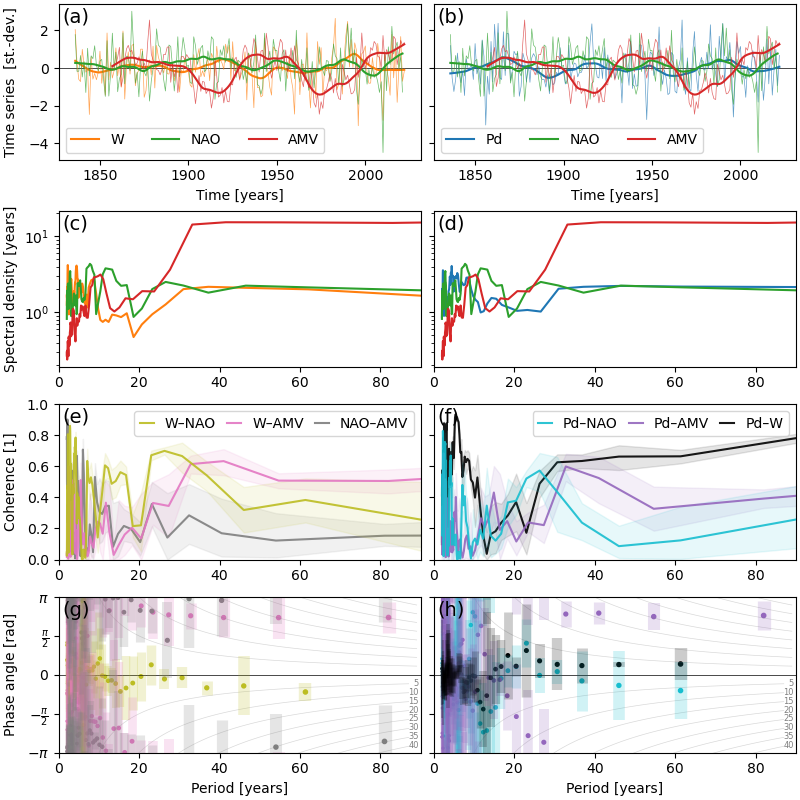

In [4]:
# spectrum contants
dt = 1     # 1/yr
tbp = 3.5  # time bandwidth
kspec = 5
p = .90

# df = df[df.index>=1890]
# df_low = df_low[df_low.index>=1890]
# df = df[df.index>=1850]
# df_low = df_low[df_low.index>=1850]

print(df.describe())

f, ax = plt.subplots(4,2, figsize=(8,8), constrained_layout=True, sharey='row')

ax[0,0].set_ylabel('Time series  [st.-dev.]')
ax[1,0].set_ylabel('Spectral density [years]')
ax[2,0].set_ylabel('Coherence [1]')
ax[3,0].set_ylabel('Phase angle [rad]')
# ax[3,0].set_yticks([])

for j in range(2):

    ax[0,j].axhline(c='k', lw=.5)
    ax[3,j].axhline(c='k', lw=.5)

    # time series
    ts_name = ['wind_w','wind_pd'][j]
    ts_color = ['C1','C0'][j]
    df[ts_name]     .plot(ax=ax[0,j], c=ts_color, lw=0.5, label='_nolegend_', alpha=.7)
    df_low[ts_name] .plot(ax=ax[0,j], c=ts_color, lw=1.5, label=['W','Pd'][j])
    df['nao']    .plot(ax=ax[0,j], c='C2', lw=0.5, label='_nolegend_', alpha=.7)
    df['amv']    .plot(ax=ax[0,j], c='C3', lw=0.5, label='_nolegend_', alpha=.7)
    df_low['nao'].plot(ax=ax[0,j], c='C2', lw=1.5, label='NAO')
    df_low['amv'].plot(ax=ax[0,j], c='C3', lw=1.5, label='AMV')
    ax[0,j].legend(ncol=3)
    ax[0,j].text(.01,.88,['(a)','(b)'][j], size=14, transform=ax[0,j].transAxes)

    a = np.arange(10,90)
    # a = np.arange(10,70)
    for t in np.arange(5,45,5):
        b = t/(a/2/np.pi)
        ax[3,j].plot(a, b, c='grey', lw=.5, alpha=.3)
        ax[3,j].plot(a[:-2],-b[:-2], c='grey', lw=.5, alpha=.3)
        ax[3,j].text(89.5,-b[-2], t, ha='right', va='center', fontsize=6, alpha=.5)
        # ax[3,j].text(69,-b[-1], t, ha='right', va='center', fontsize=6, alpha=.5)

    ts = ['W','Pd'][j]
    for i in range(3):
        zorder = [3,2,1][i]
        # spectrum
        l = [ts,'NAO','AMV'][i]
        c = [ts_color,'C2','C3'][i]
        x = [df[ts_name], df['nao'], df['amv']][i]
        x = x.dropna()
        spec, freq  = mtspec(data=x.values.flatten(), delta=dt, time_bandwidth=tbp)

        ax[1,j].plot(1/freq[1:], spec[1:], label=l, color=c)

        # coherence & phase angle
        l = [f'{ts}–NAO',f'{ts}–AMV',['NAO–AMV','Pd–W'][j]][i]
        # c = [['C8','C5','C6'],['C7','C4','C9']][j][i]
        c = [['C8','C6','C7'],['C9','C4','k']][j][i]
        (xi, xj) = [(df[ts_name],df['nao']),
                    (df[ts_name],df['amv']),
                    [(df['nao'],df['amv']), (df['wind_pd'],df['wind_w'])][j]
                    ][i]
        # if i==1 or i==2 and j==0:
            # shorten time series as AMV is shorter than NAO, W, Pd
        nonan = np.isnan(xi*xj)==False
        xi = xi.where(nonan).dropna()
        xj = xj.where(nonan).dropna()
        npts = len(xi)
        nf = int(npts/2)
        coh_dict = dict(freq=True, cohe=True, phase=True, conf=True, cohe_ci=True, phase_ci=True)
        out = mt_coherence(dt, xi, xj, tbp, kspec, nf, p, **coh_dict, iadapt=1)
        periods = 1/out['freq'][1:]
        cohe = out['cohe'][1:]
        cohel = out['cohe_ci'][1:,0]
        coheu = out['cohe_ci'][1:,1]
        ax[2,j].plot(periods, cohe , c=c, label=l, alpha=.9, zorder=zorder)
        ax[2,j].fill_between(periods, cohel, coheu, color=c, alpha=.1, zorder=zorder-1)

        phase = np.deg2rad(out['phase'][1:])
        phasel = np.deg2rad(out['phase_ci'][1:,0])
        phaseu = np.deg2rad(out['phase_ci'][1:,1])
        ax[3,j].scatter(periods, phase, c=c, s=5*np.log10(periods))
        errors = (abs(phasel-phase), abs(phaseu-phase))
        ax[3,j].errorbar(periods, phase        , errors, fmt='none', color=c, alpha=.2, elinewidth=5*np.log10(periods))
        ax[3,j].errorbar(periods, phase+2*np.pi, errors, fmt='none', color=c, alpha=.2, elinewidth=5*np.log10(periods))
        ax[3,j].errorbar(periods, phase-2*np.pi, errors, fmt='none', color=c, alpha=.2, elinewidth=5*np.log10(periods))

    ax[2,j].set_ylim(0,1)
    
    ax[3,j].set_ylim(-np.pi,np.pi)
    ax[3,j].set_yticks(np.arange(-np.pi,np.pi+1,np.pi/2))
    ax[3,j].set_yticklabels([r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
    ax[3,j].minorticks_off()

    for i in range(3):
        # ax[i+1,j].set_xscale('log')
        # ax[i+1,j].set_xlim(2,100)
        # ax[i+1,j].set_xticks([2,5,10,20,50, 100])

        ax[i+1,j].set_xlim(0,90)
        # ax[i+1,j].set_xlim(0,70)
        # ax[i+1,j].set_xlim(0,10)
        ax[i+1,j].text(.01,.88,'('+[['c','d'],['e','f'],['g','h']][i][j]+')', size=14, transform=ax[i+1,j].transAxes)

    ax[1,j].set_yscale('log')
    ax[0,j].set_xlabel('Time [years]')
    ax[3,j].set_xlabel('Period [years]')
ax[2,0].legend(ncol=3, handlelength=1, columnspacing=0.8)
ax[2,1].legend(ncol=3, handlelength=1, columnspacing=0.8)

f.align_ylabels()
# plt.savefig('figures/coherence_full.png')
plt.savefig('figures/FigC2.pdf')
# plt.savefig('figures/coherence_1890.png')
